In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import random 

from sklearn.model_selection import train_test_split, GridSearchCV
from skimage import feature
from sklearn.preprocessing import StandardScaler
from sklearn import multiclass
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers
from scipy import stats

2023-09-16 18:33:34.382985: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-16 18:33:34.424573: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-16 18:33:34.425199: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 18:33:35.029505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Using methods from other notebook
%run preprocessing_functions.ipynb

In [3]:
# Loading fer2013 dataset, it's already split in train and test data
train_data, train_labels = load_data('datasets/FER2013/train')
test_data, test_labels = load_data('datasets/FER2013/test')

In [4]:
# As we see, train dataset consists of 28709 images of 48 x 48 px
train_data.shape

(28709, 48, 48)

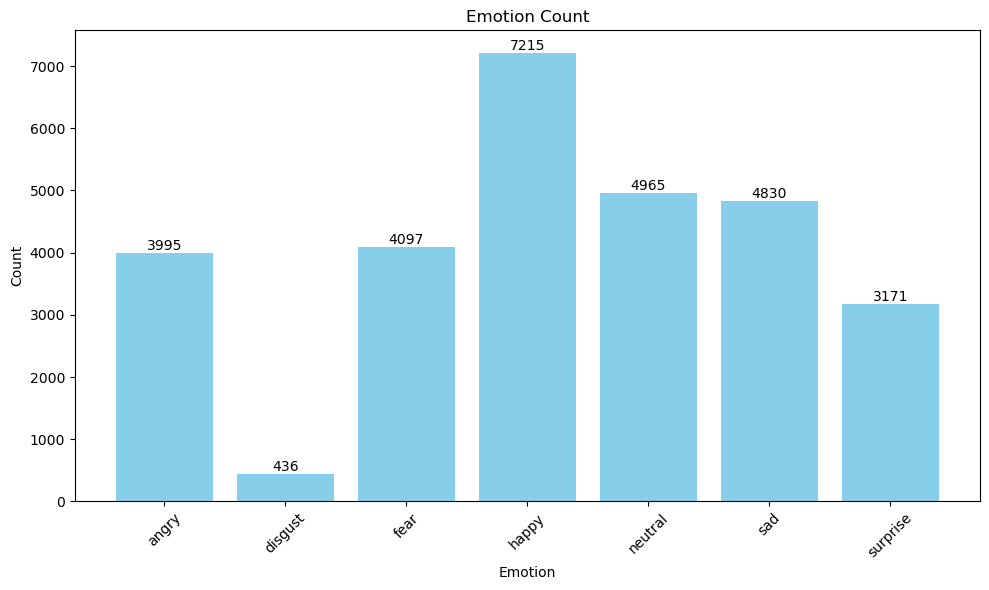

In [5]:
plot_count(train_data, train_labels)

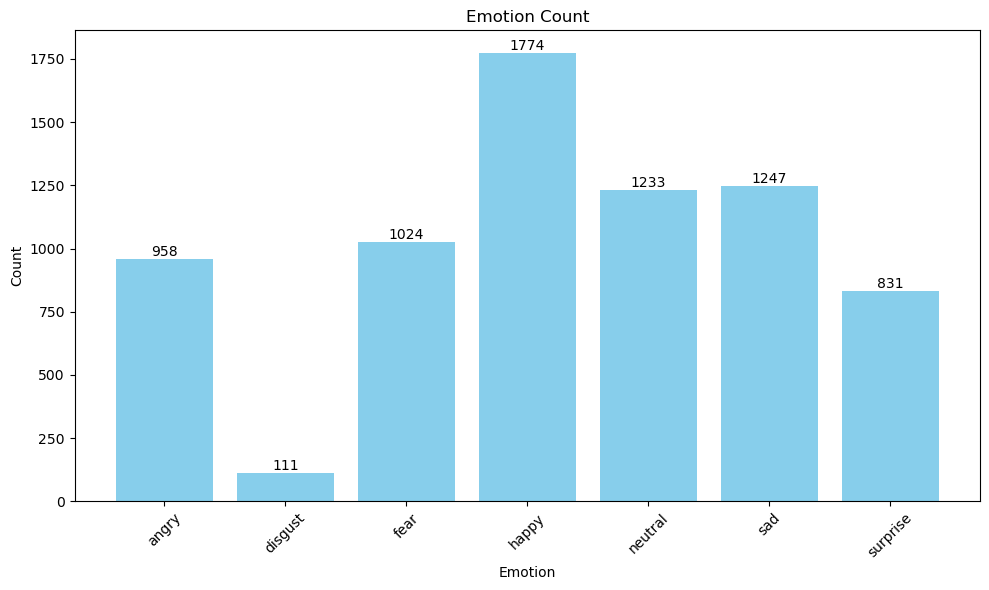

In [6]:
plot_count(test_data, test_labels)

In [7]:
# Here, we'll use different approach to unbalanced data. Because disgust is much smaller class than the others, 
# we'll make more models, and use voting when we testing

In [8]:
train_data, train_labels = add_mirrored_images_upto(train_data, train_labels, upto=436*11, include=["angry", "fear", "surprise"])

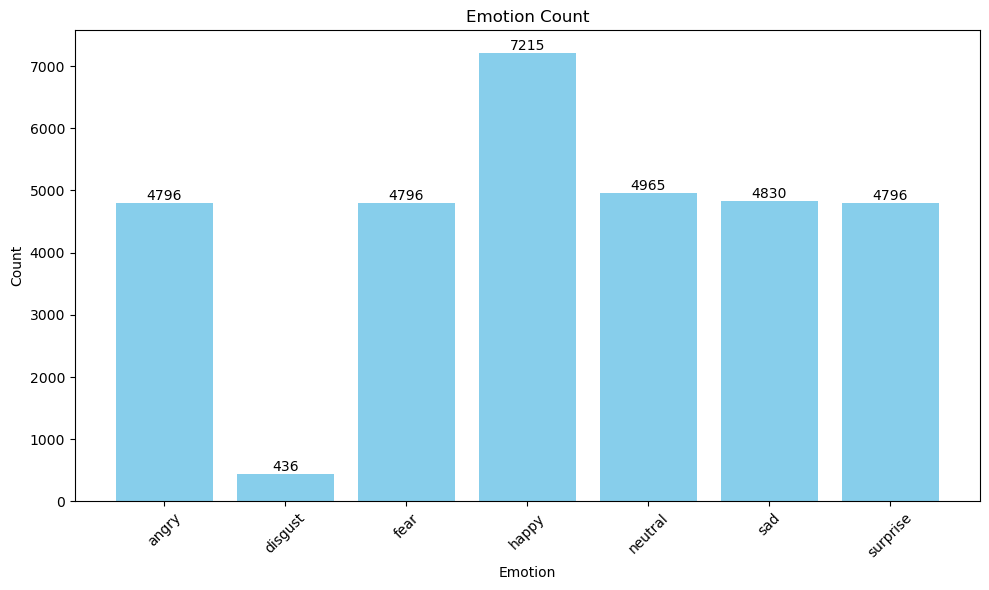

In [9]:
plot_count(train_data, train_labels)

In [10]:
seed = 12
train_data, train_labels = random_delete_upto_2(train_data, train_labels, "happy", 436*11, seed)
train_data, train_labels = random_delete_upto_2(train_data, train_labels, "neutral", 436*11, seed)
train_data, train_labels = random_delete_upto_2(train_data, train_labels, "sad", 436*11, seed)

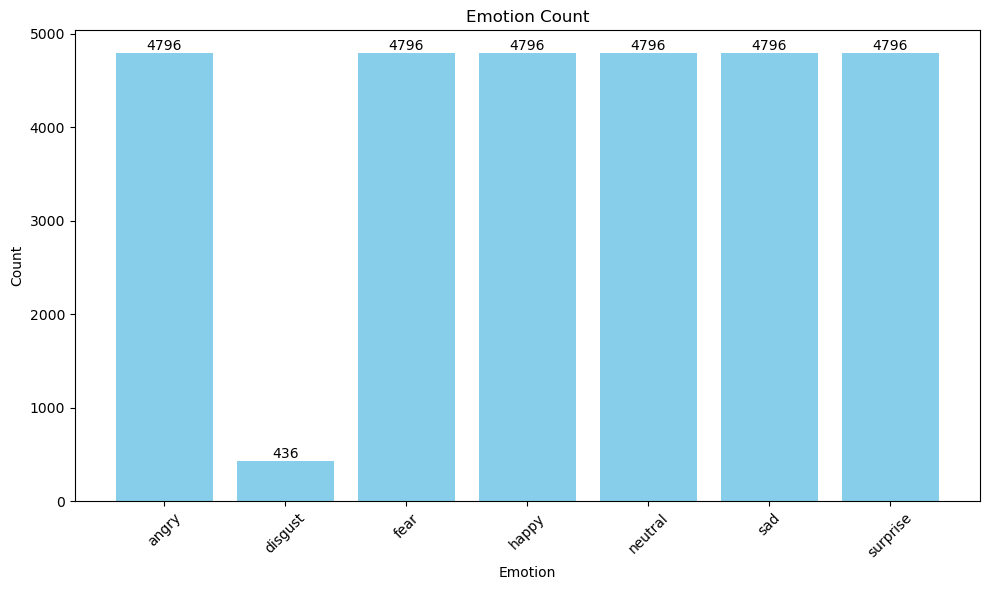

In [11]:
plot_count(train_data, train_labels)

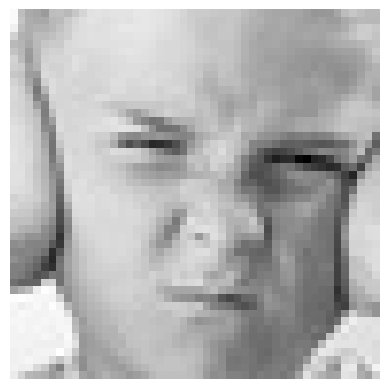

angry


In [12]:
plot_image(train_data[0], train_labels[0])

Because we have so little instances of class disgust, and so many of other, we'll make ensemble of length 11. 
In every instance of ensemble, we'll have the same 436 images of disgust, and different 436 instances from 
every other class

In [13]:
ensembles = make_ensembles(emotions=train_data, labels=train_labels, n_ensembles=11, n_counts=436, reference = "disgust")

11
2
3052
3052


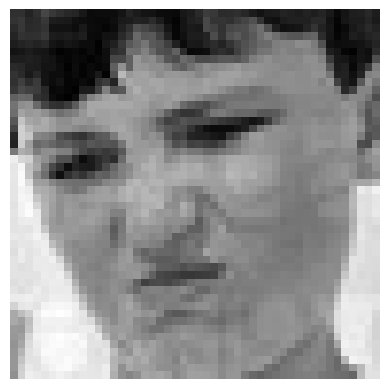

disgust


In [14]:
# As we see, we have 11 ensembles, each have list of data and labels. Data is consisted of 3052 
# instances, where each is a picture of 48 x 48 pixels

print(len(ensembles)) # Whole ensemble
print(len(ensembles[0])) # Each is consisted of images and labels
print(len(ensembles[0][0])) # 3052 instances of images
print(len(ensembles[0][1])) # 3052 instances of labels
ed0_image = ensembles[0][0][0] # first image in array
ed0_label = ensembles[0][1][0] # first label in array
plot_image(ed0_image, ed0_label)

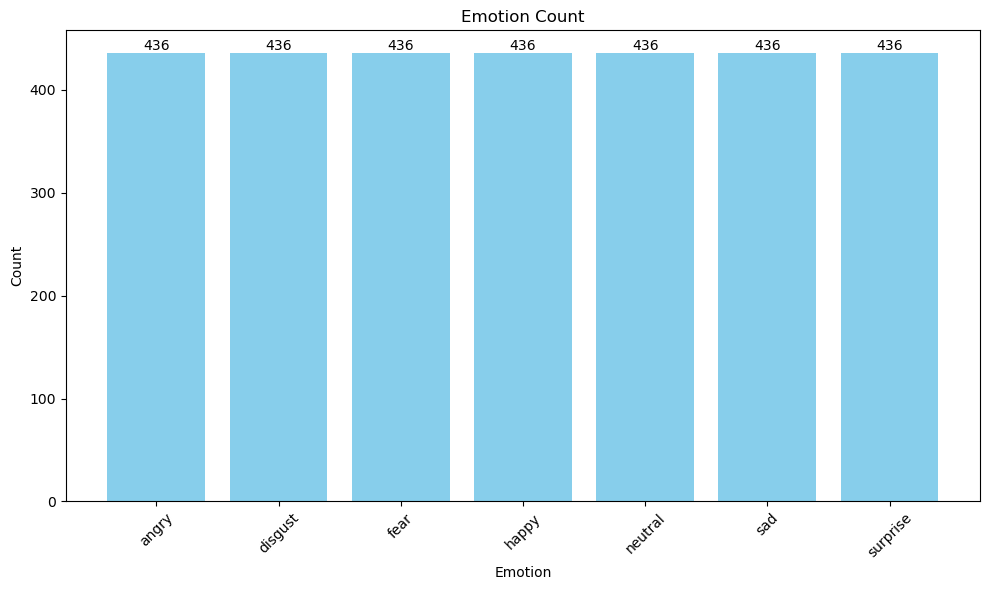

In [15]:
# Example of one ensemble datas

ed0_images = ensembles[0][0]
ed0_labels = ensembles[0][1]
plot_count(ed0_images, ed0_labels)

As we see, we have ensemble of length 11, which will serve us to make 11 models which we'll use. Later we'll use voting in order to classify our tesst instances

First approach is to use convolutional neural networks in order to classify our images

In [16]:
# INSERT CONVOLUTIONAL NETWORKS HERE

Second approach is to extract some of the features from images. In order to do that, we'll use built-in function 
local_binary_pattern from feature library. After that, we can make different SVC or neural network models which 
will be used in our classification problem.

In [17]:
# Extracting lbp features from images

train_lbp_features = []
for image in train_data:
    lbp_feature = compute_lbp(image, 3, 555)
    train_lbp_features.append(lbp_feature)


test_lbp_features = []
for image in test_data:
    lbp_feature = compute_lbp(image, 3, 555)
    test_lbp_features.append(lbp_feature)


In [18]:
# # Extracting lbp features from images

# train_lbp_features = []

# for ensemble in ensembles:
#     lbp_features = []
    
#     for image in ensemble[0]:
#         lbp_feature = compute_lbp(image, 3, 555)
#         lbp_features.append(lbp_feature)
        
#     train_lbp_features.append(lbp_feature)


# test_lbp_features = []

# for image in test_data:
#     lbp_feature = compute_lbp(image, 3, 555)
#     test_lbp_features.append(lbp_feature)


In [19]:
ensembles = make_ensembles(emotions=train_lbp_features, labels=train_labels, n_ensembles=11, n_counts=436, reference = "disgust")

In [20]:
train_lbp_features[0]

array([0.04817708, 0.00217014, 0.        , 0.00043403, 0.00086806,
       0.        , 0.00043403, 0.00390625, 0.00043403, 0.        ,
       0.00173611, 0.        , 0.00086806, 0.00173611, 0.00173611,
       0.00043403, 0.00130208, 0.00130208, 0.00260417, 0.00434028,
       0.00043403, 0.00043403, 0.00086806, 0.        , 0.00086806,
       0.00086806, 0.        , 0.        , 0.        , 0.00043403,
       0.00217014, 0.00303819, 0.00347222, 0.        , 0.00086806,
       0.00086806, 0.00086806, 0.00086806, 0.00303819, 0.        ,
       0.        , 0.        , 0.00173611, 0.00477431, 0.00217014,
       0.00086806, 0.00130208, 0.00130208, 0.00043403, 0.00086806,
       0.00086806, 0.00086806, 0.        , 0.00043403, 0.00086806,
       0.00086806, 0.00130208, 0.00043403, 0.        , 0.00130208,
       0.00043403, 0.00130208, 0.00086806, 0.00086806, 0.00086806,
       0.00043403, 0.00043403, 0.00260417, 0.00303819, 0.00217014,
       0.00043403, 0.00043403, 0.00086806, 0.00086806, 0.00217

In [21]:
print(len(train_lbp_features))

29212


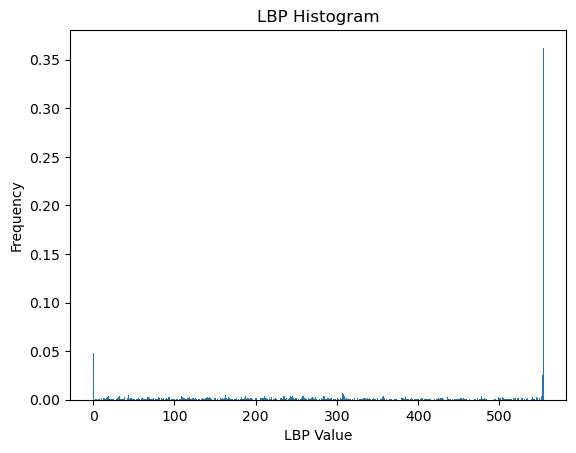

In [22]:
plot_lbp_hist(train_lbp_features[0])

In [23]:
# As we see, we have 11 ensembles, each have list of data and labels. Data is consisted of 3052 
# instances with dimension 555

print(len(ensembles))
print(len(ensembles[0]))
print(len(ensembles[0][0]))
print(len(ensembles[0][1]))
print(len(ensembles[0][0][0]))

11
2
3052
3052
555


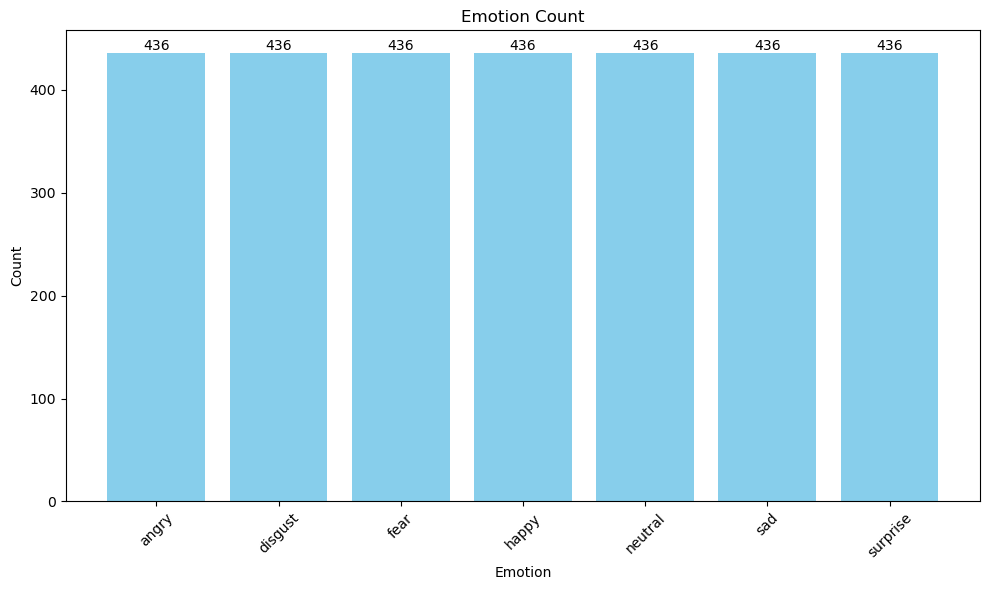

In [24]:
# Example of one ensemble datas

ed0_lbp_features = ensembles[0][0]
ed0_labels = ensembles[0][1]
plot_count(ed0_lbp_features, ed0_labels)

In [25]:
# Look for best CSV configuration
def find_best_conf(train_data, train_labels):
    
    scaler = StandardScaler()
    standardized_train_data = scaler.fit_transform(train_data)

    kernels = ['linear', 'rbf', 'poly', 'sigmoid']
    c = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1]
    gammas = [0.01, 0.1, 1]

    clf = svm.SVC()
    clf.fit(standardized_train_data, train_labels)
    param_grid = dict(kernel=kernels, C=c, gamma=gammas)

    # GridSearchCV accepts dictionary with different hyper-parameters we want to try on the SVM model. 
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)

    grid.fit(standardized_train_data, train_labels)
    return grid

In [26]:
# Finding best parameters

train_lbp_features_ens, train_labels_ens = ensembles[0]

grid = find_best_conf(train_lbp_features_ens, train_labels_ens)

best_kernel = grid.best_params_['kernel']
best_c = grid.best_params_['C']
best_gamma = grid.best_params_['gamma']

print("best kernel: ", best_kernel,
      "\nbest c: ", best_c, 
      "\nbest gamma: ", best_gamma)

best kernel:  poly 
best c:  1e-05 
best gamma:  1


In [27]:
# Train 11 SVM models on these subsets

models = []
scalers = []

cs = [best_c + diff for diff in  [-(best_c*0.5), 0, best_c*0.5]]
gammas = [best_gamma + diff for diff in  [-(best_gamma*0.5), 0, best_gamma*0.5]]

i = 0
for c in cs:
    for gamma in gammas:
        print("Training model: ", i)

        train_lbp_features_ens, train_labels_ens = ensembles[i]
        
        scaler = StandardScaler()
        standardized_train_lbf_features_ens = scaler.fit_transform(train_lbp_features_ens)
        scalers.append(scaler)
        
        model = svm.SVC(kernel=best_kernel, C=c, gamma=gamma) 
        model.fit(standardized_train_lbf_features_ens, train_labels_ens)
        models.append(model)
        i += 1
        
k = i
for i in range(k, k+2):
    print("Training model: ", i)
        
    train_lbp_features_ens, train_labels_ens = ensembles[i]
    
    scaler = StandardScaler()
    standardized_train_lbf_features_ens = scaler.fit_transform(train_lbp_features_ens)
    scalers.append(scaler)
    
    model = svm.SVC(kernel=best_kernel, C=best_c, gamma=best_gamma) 
    model.fit(standardized_train_lbf_features_ens, train_labels_ens)
    models.append(model)
    i += 1


Training model:  0
Training model:  1
Training model:  2
Training model:  3
Training model:  4
Training model:  5
Training model:  6
Training model:  7
Training model:  8
Training model:  9
Training model:  10


In [28]:
# Every model has it's own prediction and scaler

predictions = []
for i in range(len(models)):
    model = models[i]
    scaler = scalers[i]
    
    standardized_test_lbp_features = scaler.transform(test_lbp_features)
    prediction = model.predict(standardized_test_lbp_features)
    
    predictions.append(prediction)
    
majority_pred = stats.mode(predictions, axis=0).mode[0]

generate_report(test_labels, majority_pred)

Confusion matrix: 
 [[239  22  29 178  79  19 392]
 [ 13  60   1  11   6   0  20]
 [126  30  99 178 102  26 463]
 [203  41  30 799 148  40 513]
 [125  35  25 298 296  33 421]
 [227  37  41 293 153  95 401]
 [ 61  11  14  68  45  18 614]] 
F1 score: 
 0.28067492228135543 
Accuracy: 
 0.3067706882139872 
Classification report: 
               precision    recall  f1-score   support

       angry       0.24      0.25      0.24       958
     disgust       0.25      0.54      0.35       111
        fear       0.41      0.10      0.16      1024
       happy       0.44      0.45      0.44      1774
     neutral       0.36      0.24      0.29      1233
         sad       0.41      0.08      0.13      1247
    surprise       0.22      0.74      0.34       831

    accuracy                           0.31      7178
   macro avg       0.33      0.34      0.28      7178
weighted avg       0.36      0.31      0.28      7178



In [29]:
# Training 11 neural network models
    
number_of_classes = 7
label_to_int_mapping = {label: idx for idx, label in enumerate(np.unique(test_labels))}
int_to_label_mapping = {idx: label for label, idx in label_to_int_mapping.items()}

def create_nn_model(input_shape, seed = None):
    
    if (seed != None):
        random.seed(seed)
        np.random.seed(seed)
        
    model = Sequential([
        InputLayer(input_shape=(input_shape)),
        Dense(units=random.choice([64, 128]), activation='relu'), 
        Dropout(rate=random.uniform(0.4, 0.7)),
        Dense(units=random.choice([16, 32, 64]), activation='relu'),
        Dropout(rate=random.uniform(0.2, 0.5)),
        Dense(units=number_of_classes, activation='softmax')
    ])
    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

models = []
scalers = []  
 
i = 0
for i in range(11):
        print("Training model: ", i)

        train_lbp_features_ens, train_labels_ens = ensembles[i]
     
        train_labels_ens_int = np.array([label_to_int_mapping[label] for label in train_labels_ens])
        y_train_cat = keras.utils.to_categorical(train_labels_ens_int, number_of_classes)

        scaler = StandardScaler()
        standardized_train_lbf_features_ens = scaler.fit_transform(train_lbp_features_ens)
        scalers.append(scaler)
        
        model = create_nn_model(standardized_train_lbf_features_ens.shape[1])   
        model.fit(standardized_train_lbf_features_ens, y_train_cat, epochs=100, batch_size=32)
        models.append(model)
        i += 1


Training model:  0
Epoch 1/100
96/96 [==============================] - 1s 2ms/step - loss: 2.6587 - accuracy: 0.1484
Epoch 2/100
96/96 [==============================] - 0s 2ms/step - loss: 2.1337 - accuracy: 0.1720
Epoch 3/100
96/96 [==============================] - 0s 2ms/step - loss: 2.0202 - accuracy: 0.1687
Epoch 4/100
96/96 [==============================] - 0s 2ms/step - loss: 1.9679 - accuracy: 0.1796
Epoch 5/100
96/96 [==============================] - 0s 2ms/step - loss: 1.9313 - accuracy: 0.1927
Epoch 6/100
96/96 [==============================] - 0s 2ms/step - loss: 1.9109 - accuracy: 0.2097
Epoch 7/100
96/96 [==============================] - 0s 2ms/step - loss: 1.8888 - accuracy: 0.2189
Epoch 8/100
96/96 [==============================] - 0s 2ms/step - loss: 1.8814 - accuracy: 0.2280
Epoch 9/100
96/96 [==============================] - 0s 2ms/step - loss: 1.8554 - accuracy: 0.2425
Epoch 10/100
96/96 [==============================] - 0s 2ms/step - loss: 1.8331 - accurac

96/96 [==============================] - 0s 2ms/step - loss: 0.7100 - accuracy: 0.7346
Epoch 83/100
96/96 [==============================] - 0s 2ms/step - loss: 0.7600 - accuracy: 0.7235
Epoch 84/100
96/96 [==============================] - 0s 2ms/step - loss: 0.7348 - accuracy: 0.7326
Epoch 85/100
96/96 [==============================] - 0s 2ms/step - loss: 0.7170 - accuracy: 0.7366
Epoch 86/100
96/96 [==============================] - 0s 2ms/step - loss: 0.7435 - accuracy: 0.7274
Epoch 87/100
96/96 [==============================] - 0s 2ms/step - loss: 0.7270 - accuracy: 0.7379
Epoch 88/100
96/96 [==============================] - 0s 2ms/step - loss: 0.7059 - accuracy: 0.7431
Epoch 89/100
96/96 [==============================] - 0s 2ms/step - loss: 0.7091 - accuracy: 0.7438
Epoch 90/100
96/96 [==============================] - 0s 2ms/step - loss: 0.6904 - accuracy: 0.7493
Epoch 91/100
96/96 [==============================] - 0s 2ms/step - loss: 0.6996 - accuracy: 0.7500
Epoch 92/100


96/96 [==============================] - 0s 2ms/step - loss: 0.5847 - accuracy: 0.7952
Epoch 64/100
96/96 [==============================] - 0s 2ms/step - loss: 0.5404 - accuracy: 0.8113
Epoch 65/100
96/96 [==============================] - 0s 2ms/step - loss: 0.5505 - accuracy: 0.8050
Epoch 66/100
96/96 [==============================] - 0s 2ms/step - loss: 0.5412 - accuracy: 0.8028
Epoch 67/100
96/96 [==============================] - 0s 2ms/step - loss: 0.5217 - accuracy: 0.8123
Epoch 68/100
96/96 [==============================] - 0s 2ms/step - loss: 0.5221 - accuracy: 0.8168
Epoch 69/100
96/96 [==============================] - 0s 2ms/step - loss: 0.4931 - accuracy: 0.8372
Epoch 70/100
96/96 [==============================] - 0s 2ms/step - loss: 0.5040 - accuracy: 0.8247
Epoch 71/100
96/96 [==============================] - 0s 2ms/step - loss: 0.4874 - accuracy: 0.8339
Epoch 72/100
96/96 [==============================] - 0s 2ms/step - loss: 0.4856 - accuracy: 0.8309
Epoch 73/100


96/96 [==============================] - 0s 2ms/step - loss: 1.0886 - accuracy: 0.6016
Epoch 45/100
96/96 [==============================] - 0s 2ms/step - loss: 1.0238 - accuracy: 0.6219
Epoch 46/100
96/96 [==============================] - 0s 2ms/step - loss: 1.0321 - accuracy: 0.6176
Epoch 47/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9993 - accuracy: 0.6317
Epoch 48/100
96/96 [==============================] - 0s 3ms/step - loss: 1.0122 - accuracy: 0.6314
Epoch 49/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9941 - accuracy: 0.6245
Epoch 50/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9499 - accuracy: 0.6429
Epoch 51/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9668 - accuracy: 0.6491
Epoch 52/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9273 - accuracy: 0.6547
Epoch 53/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9290 - accuracy: 0.6530
Epoch 54/100


96/96 [==============================] - 0s 2ms/step - loss: 1.4850 - accuracy: 0.4171
Epoch 26/100
96/96 [==============================] - 0s 2ms/step - loss: 1.4579 - accuracy: 0.4135
Epoch 27/100
96/96 [==============================] - 0s 2ms/step - loss: 1.4629 - accuracy: 0.4250
Epoch 28/100
96/96 [==============================] - 0s 2ms/step - loss: 1.4517 - accuracy: 0.4273
Epoch 29/100
96/96 [==============================] - 0s 2ms/step - loss: 1.4235 - accuracy: 0.4479
Epoch 30/100
96/96 [==============================] - 0s 2ms/step - loss: 1.3776 - accuracy: 0.4551
Epoch 31/100
96/96 [==============================] - 0s 2ms/step - loss: 1.3456 - accuracy: 0.4820
Epoch 32/100
96/96 [==============================] - 0s 2ms/step - loss: 1.3467 - accuracy: 0.4613
Epoch 33/100
96/96 [==============================] - 0s 2ms/step - loss: 1.3371 - accuracy: 0.4669
Epoch 34/100
96/96 [==============================] - 0s 2ms/step - loss: 1.3112 - accuracy: 0.4807
Epoch 35/100


96/96 [==============================] - 0s 2ms/step - loss: 1.8099 - accuracy: 0.2723
Epoch 7/100
96/96 [==============================] - 0s 2ms/step - loss: 1.7689 - accuracy: 0.2952
Epoch 8/100
96/96 [==============================] - 0s 2ms/step - loss: 1.7528 - accuracy: 0.2969
Epoch 9/100
96/96 [==============================] - 0s 2ms/step - loss: 1.7015 - accuracy: 0.3352
Epoch 10/100
96/96 [==============================] - 0s 2ms/step - loss: 1.6853 - accuracy: 0.3336
Epoch 11/100
96/96 [==============================] - 0s 2ms/step - loss: 1.6566 - accuracy: 0.3427
Epoch 12/100
96/96 [==============================] - 0s 2ms/step - loss: 1.6052 - accuracy: 0.3771
Epoch 13/100
96/96 [==============================] - 0s 2ms/step - loss: 1.5719 - accuracy: 0.3866
Epoch 14/100
96/96 [==============================] - 0s 2ms/step - loss: 1.5231 - accuracy: 0.4181
Epoch 15/100
96/96 [==============================] - 0s 2ms/step - loss: 1.5032 - accuracy: 0.4194
Epoch 16/100
96/

96/96 [==============================] - 0s 2ms/step - loss: 0.4285 - accuracy: 0.8526
Epoch 89/100
96/96 [==============================] - 0s 2ms/step - loss: 0.4540 - accuracy: 0.8506
Epoch 90/100
96/96 [==============================] - 0s 2ms/step - loss: 0.4257 - accuracy: 0.8542
Epoch 91/100
96/96 [==============================] - 0s 2ms/step - loss: 0.4308 - accuracy: 0.8542
Epoch 92/100
96/96 [==============================] - 0s 2ms/step - loss: 0.4022 - accuracy: 0.8647
Epoch 93/100
96/96 [==============================] - 0s 2ms/step - loss: 0.4037 - accuracy: 0.8621
Epoch 94/100
96/96 [==============================] - 0s 2ms/step - loss: 0.4191 - accuracy: 0.8552
Epoch 95/100
96/96 [==============================] - 0s 2ms/step - loss: 0.4108 - accuracy: 0.8644
Epoch 96/100
96/96 [==============================] - 0s 2ms/step - loss: 0.3835 - accuracy: 0.8676
Epoch 97/100
96/96 [==============================] - 0s 2ms/step - loss: 0.3688 - accuracy: 0.8739
Epoch 98/100


96/96 [==============================] - 0s 2ms/step - loss: 0.9806 - accuracy: 0.6422
Epoch 70/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9533 - accuracy: 0.6484
Epoch 71/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9935 - accuracy: 0.6452
Epoch 72/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9545 - accuracy: 0.6497
Epoch 73/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9635 - accuracy: 0.6363
Epoch 74/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9612 - accuracy: 0.6540
Epoch 75/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9417 - accuracy: 0.6573
Epoch 76/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9432 - accuracy: 0.6501
Epoch 77/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9468 - accuracy: 0.6661
Epoch 78/100
96/96 [==============================] - 0s 2ms/step - loss: 0.8934 - accuracy: 0.6697
Epoch 79/100


96/96 [==============================] - 0s 2ms/step - loss: 0.8925 - accuracy: 0.6563
Epoch 51/100
96/96 [==============================] - 0s 2ms/step - loss: 0.8551 - accuracy: 0.6691
Epoch 52/100
96/96 [==============================] - 0s 2ms/step - loss: 0.8601 - accuracy: 0.6740
Epoch 53/100
96/96 [==============================] - 0s 2ms/step - loss: 0.8279 - accuracy: 0.6822
Epoch 54/100
96/96 [==============================] - 0s 2ms/step - loss: 0.8256 - accuracy: 0.6812
Epoch 55/100
96/96 [==============================] - 0s 2ms/step - loss: 0.8164 - accuracy: 0.6792
Epoch 56/100
96/96 [==============================] - 0s 2ms/step - loss: 0.7867 - accuracy: 0.6855
Epoch 57/100
96/96 [==============================] - 0s 2ms/step - loss: 0.7950 - accuracy: 0.6894
Epoch 58/100
96/96 [==============================] - 0s 2ms/step - loss: 0.7790 - accuracy: 0.6864
Epoch 59/100
96/96 [==============================] - 0s 2ms/step - loss: 0.7655 - accuracy: 0.7015
Epoch 60/100


96/96 [==============================] - 0s 2ms/step - loss: 1.0907 - accuracy: 0.5865
Epoch 32/100
96/96 [==============================] - 0s 2ms/step - loss: 1.0329 - accuracy: 0.6127
Epoch 33/100
96/96 [==============================] - 0s 2ms/step - loss: 1.0283 - accuracy: 0.6209
Epoch 34/100
96/96 [==============================] - 0s 2ms/step - loss: 1.0089 - accuracy: 0.6320
Epoch 35/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9986 - accuracy: 0.6232
Epoch 36/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9686 - accuracy: 0.6468
Epoch 37/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9252 - accuracy: 0.6589
Epoch 38/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9194 - accuracy: 0.6619
Epoch 39/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9163 - accuracy: 0.6727
Epoch 40/100
96/96 [==============================] - 0s 2ms/step - loss: 0.8845 - accuracy: 0.6782
Epoch 41/100


96/96 [==============================] - 0s 2ms/step - loss: 1.7792 - accuracy: 0.2877
Epoch 13/100
96/96 [==============================] - 0s 1ms/step - loss: 1.7544 - accuracy: 0.2955
Epoch 14/100
96/96 [==============================] - 0s 2ms/step - loss: 1.7461 - accuracy: 0.3070
Epoch 15/100
96/96 [==============================] - 0s 2ms/step - loss: 1.6935 - accuracy: 0.3280
Epoch 16/100
96/96 [==============================] - 0s 2ms/step - loss: 1.6919 - accuracy: 0.3270
Epoch 17/100
96/96 [==============================] - 0s 2ms/step - loss: 1.6572 - accuracy: 0.3434
Epoch 18/100
96/96 [==============================] - 0s 2ms/step - loss: 1.6388 - accuracy: 0.3427
Epoch 19/100
96/96 [==============================] - 0s 2ms/step - loss: 1.6166 - accuracy: 0.3614
Epoch 20/100
96/96 [==============================] - 0s 2ms/step - loss: 1.6081 - accuracy: 0.3630
Epoch 21/100
96/96 [==============================] - 0s 2ms/step - loss: 1.5799 - accuracy: 0.3778
Epoch 22/100


96/96 [==============================] - 0s 2ms/step - loss: 0.7744 - accuracy: 0.7192
Epoch 95/100
96/96 [==============================] - 0s 2ms/step - loss: 0.7634 - accuracy: 0.7195
Epoch 96/100
96/96 [==============================] - 0s 2ms/step - loss: 0.7371 - accuracy: 0.7349
Epoch 97/100
96/96 [==============================] - 0s 2ms/step - loss: 0.7483 - accuracy: 0.7274
Epoch 98/100
96/96 [==============================] - 0s 2ms/step - loss: 0.7557 - accuracy: 0.7284
Epoch 99/100
96/96 [==============================] - 0s 2ms/step - loss: 0.7466 - accuracy: 0.7346
Epoch 100/100
96/96 [==============================] - 0s 2ms/step - loss: 0.7342 - accuracy: 0.7280
Training model:  9
Epoch 1/100
96/96 [==============================] - 1s 2ms/step - loss: 2.4069 - accuracy: 0.1543
Epoch 2/100
96/96 [==============================] - 0s 2ms/step - loss: 2.0165 - accuracy: 0.1923
Epoch 3/100
96/96 [==============================] - 0s 2ms/step - loss: 1.9020 - accuracy: 0.2

96/96 [==============================] - 0s 3ms/step - loss: 0.2843 - accuracy: 0.9020
Epoch 76/100
96/96 [==============================] - 0s 2ms/step - loss: 0.2877 - accuracy: 0.8984
Epoch 77/100
96/96 [==============================] - 0s 3ms/step - loss: 0.2890 - accuracy: 0.8974
Epoch 78/100
96/96 [==============================] - 0s 2ms/step - loss: 0.2788 - accuracy: 0.9017
Epoch 79/100
96/96 [==============================] - 0s 2ms/step - loss: 0.2709 - accuracy: 0.9102
Epoch 80/100
96/96 [==============================] - 0s 2ms/step - loss: 0.2749 - accuracy: 0.9004
Epoch 81/100
96/96 [==============================] - 0s 2ms/step - loss: 0.2631 - accuracy: 0.9047
Epoch 82/100
96/96 [==============================] - 0s 2ms/step - loss: 0.2925 - accuracy: 0.9030
Epoch 83/100
96/96 [==============================] - 0s 3ms/step - loss: 0.3147 - accuracy: 0.8994
Epoch 84/100
96/96 [==============================] - 0s 3ms/step - loss: 0.2880 - accuracy: 0.9043
Epoch 85/100


96/96 [==============================] - 0s 2ms/step - loss: 1.0395 - accuracy: 0.6137
Epoch 57/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9976 - accuracy: 0.6301
Epoch 58/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9961 - accuracy: 0.6304
Epoch 59/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9638 - accuracy: 0.6317
Epoch 60/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9649 - accuracy: 0.6311
Epoch 61/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9726 - accuracy: 0.6373
Epoch 62/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9393 - accuracy: 0.6353
Epoch 63/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9982 - accuracy: 0.6271
Epoch 64/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9651 - accuracy: 0.6406
Epoch 65/100
96/96 [==============================] - 0s 2ms/step - loss: 0.9236 - accuracy: 0.6583
Epoch 66/100


In [30]:
print(int_to_label_mapping)
print(int_to_label_mapping[0])

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
angry


In [31]:
# Every model has it's own prediction and scaler


predictions = []
for i in range(len(models)):
    model = models[i]
    scaler = scalers[i]
    
    standardized_test_lbp_features = scaler.transform(test_lbp_features)
    prediction = model.predict(standardized_test_lbp_features)
    predictions.append([ int_to_label_mapping[np.argmax(prediction[i])] for i in range(len(prediction)) ])

    
majority_pred = stats.mode(predictions, axis=0).mode[0]

generate_report(test_labels, majority_pred)

225/225 [==============================] - 0s 930us/step
Confusion matrix: 
 [[283  82 167 100 116 132  78]
 [ 16  56  13  11   5   5   5]
 [210  93 258  93 116 147 107]
 [281 168 243 584 192 217  89]
 [188 110 181 187 324 155  88]
 [259 111 227 146 155 284  65]
 [139  60 181  66  67  25 293]] 
F1 score: 
 0.30275373472645395 
Accuracy: 
 0.29005293953747563 
Classification report: 
               precision    recall  f1-score   support

       angry       0.21      0.30      0.24       958
     disgust       0.08      0.50      0.14       111
        fear       0.20      0.25      0.22      1024
       happy       0.49      0.33      0.39      1774
     neutral       0.33      0.26      0.29      1233
         sad       0.29      0.23      0.26      1247
    surprise       0.40      0.35      0.38       831

    accuracy                           0.29      7178
   macro avg       0.29      0.32      0.28      7178
weighted avg       0.33      0.29      0.30      7178

